In [1]:
# %matplotlib inline
# %load_ext tensorboard

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import sys
import tensorflow as tf
from tensorflow import keras  # tf.keras
import time

2023-05-31 19:19:29.386501: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-31 19:19:29.537681: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-31 19:19:30.484008: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-05-31 19:19:30.484113: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

In [3]:
print("python", sys.version)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

python 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:21) 
[GCC 9.4.0]
matplotlib 3.5.3
numpy 1.21.6
pandas 1.3.5
sklearn 1.0.2
tensorflow 2.11.0
keras.api._v2.keras 2.11.0


In [4]:
assert sys.version_info >= (3, 5) # Python ≥3.5 required
assert tf.__version__ >= "2.0"    # TensorFlow ≥2.0 required

In [5]:
from Mike_NB_tools import *
from Transformer import *

In [6]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            # logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            # print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

In [7]:
from datetime import datetime, timedelta
import sys 
sys.path.append('..')
import json

In [8]:
#==================== Load candle data into 'table' with shape of (time, markets, 10 fields) ====================

# CandleFile = "18-01-01-00-00-23-05-20-05-55-1h" #
CandleFile = "18-01-01-00-00-23-05-20-20-23-5m"
# CandleFile = "18-01-01-00-00-23-05-20-09-11-1d"
# CandleFile = "18-01-01-00-00-23-05-21-04-12-15m"

table = np.load( os.path.join( "/mnt/data/Trading/Candles", "table-" + CandleFile + ".npy") )
table = np.swapaxes(table, 0, 1)
print("table: {}".format(table.shape))

table: (47137, 336, 10)


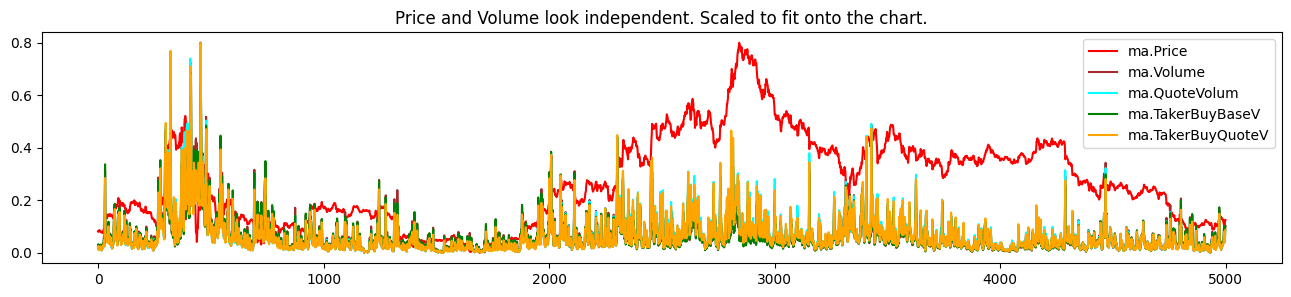

In [9]:
market = 5
Show_Price_Volume_10(table[:, market, :], 1, 1, 5000)

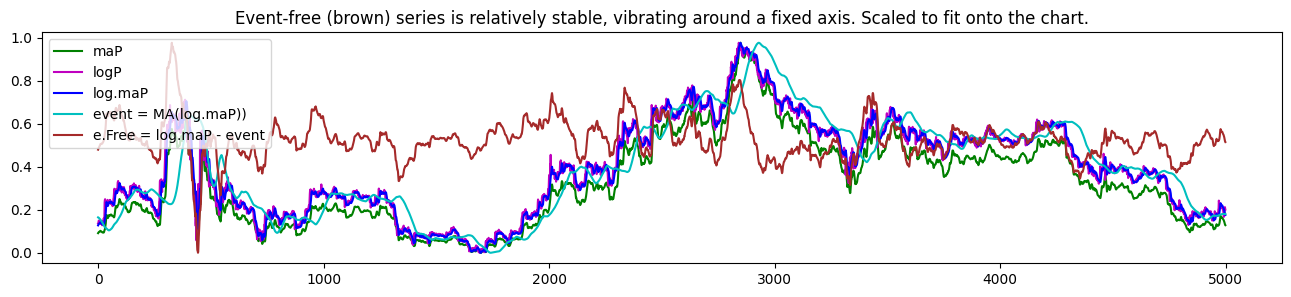

In [10]:
Event_Free_Learning_Scheme_10(table[:, market, :], 3, 30, 5000)

In [11]:
#==================== Delete 7 candle fields from 'table'. ====================
# table.shape becomes (time, markets, ['ClosePrice', 'BaseVolume', 'BuyerBaseVolume'] )

CandleMarks = table[:, :, 9] # keep it for later use
table = np.delete(table, [0, 1, 2, 5, 6, 8, 9], axis = 2) # delete Open, High, Low, qVolume, #Trades, bQVolume, CandleMarks

table_markets = []
with open( os.path.join( "/mnt/data/Trading/Candles", "reports-" + CandleFile + ".json"), "r") as f:
    reports = json.loads(f.read())
print(reports[:2])

markets = [ s[0: s.find(':')] for s in reports if 'Success' in s ]
assert table.shape[1] == len(markets)
print(table.shape, len(markets), markets[:2])

['ALICEUSDT: 47137, 28074 created. Success.', 'DOTUSDT: 47137, 23082 created. Success.']
(47137, 336, 3) 336 ['ALICEUSDT', 'DOTUSDT']


In [12]:
#==================== Restore timestamps_abs. ====================

start = datetime( 2000+int(CandleFile[0:2]), int(CandleFile[3:5]), int(CandleFile[6:8]), int(CandleFile[9:11]), int(CandleFile[12:14]) )
start_ts = round(datetime.timestamp(start))
interval = CandleFile[ CandleFile.find('-', len(CandleFile) - 4) + 1 : ]
interval_s = round(intervalToMilliseconds(interval) / 1000)
timestamps_abs = np.array( range(start_ts, start_ts + table.shape[0] * interval_s, interval_s), dtype=int)
assert timestamps_abs.shape[0] == table.shape[0]
print(start_ts, interval_s, timestamps_abs.shape, timestamps_abs[:3])

1514764800 3600 (47137,) [1514764800 1514768400 1514772000]


In [13]:
# # Find market clusters # temporary
# from sklearn.metrics import pairwise

# distances = np.zeros( (table.shape[1], table.shape[1]), dtype=float)

# # Find dependency distance
# for m in range(table.shape[1]):
#     distances[m, m] = 0.
#     for n in range(m+1, table.shape[1]):
#         mask = (CandleMarks[:, m] + CandleMarks[:, n] == 0) # CandleMarks == 0 : true full candles, CandleMarks = -1: price interpolated , CandleMarks = -2: coincodex prices
#         pm = table[mask, m, 0][np.newaxis]
#         pn = table[mask, n, 0][np.newaxis]
#         distances[m, n] = sklearn.metrics.pairwise.cosine_distances(pm, pn)
#         distances[n, m] = distances[m, n]

In [14]:
# from sklearn.cluster import OPTICS
# clustering = OPTICS(metric='precomputed', n_jobs=-1).fit(distances)
# print( clustering.labels_ )

# np.reshape(np.argwhere(clustering.labels_ == 1), -1)

# market_clusters = [ [ markets[ id ] for id in np.reshape(np.argwhere(clustering.labels_ == label), -1) ] for label in range(np.max(clustering.labels_))]
# print(market_clusters)

In [15]:
# cluster = 0
# ids = np.reshape(np.argwhere(clustering.labels_ == cluster), -1)
# series = [ [table[:, id, 0], markets[id] ] for id in ids ]
# PoltNormalized("Market cluster 0. Recent prices are mediocre. Shorter history.", series, color = 'auto')

In [16]:
# cluster = 1
# ids = np.reshape(np.argwhere(clustering.labels_ == cluster), -1)
# series = [ [table[:, id, 0], markets[id] ] for id in ids ]
# PoltNormalized("Market cluster 1. Vanished recently. Shorter history, Trends later", series, color = 'auto')

In [17]:
# cluster = 2
# ids = np.reshape(np.argwhere(clustering.labels_ == cluster), -1)
# series = [ [table[:, id, 0], markets[id] ] for id in ids ]
# PoltNormalized("Market cluster 2. Not vanished recently. Longer hostory. Trends earlier", series, color = 'auto')

In [18]:
#==================== Define 'save_to_multiple_csv_files' ====================

def save_to_multiple_csv_files(data, times, sample_anchors, name_prefix, Nx, x_indices, Ny, y_indices, header=None, n_parts=10):
    path_format = "{}_{:02d}.csv"

    filenames = []
    for file_idx, anchors in enumerate(np.array_split(sample_anchors, n_parts)):
        part_csv = path_format.format(name_prefix, file_idx)
        filenames.append(part_csv)
        with open(part_csv, "wt", encoding="utf-8") as f:
            if header is not None:
                f.write(header)
                f.write("\n")
            for anchor in anchors:
                x = np.reshape(data[anchor: anchor + Nx][:, x_indices[0]][:, :, x_indices[1]], -1)
                x_time = np.reshape(times[anchor: anchor + Nx], -1)
                x = np.concatenate((x, x_time))
                f.write(",".join([str(col) for col in x]))
                y = np.reshape(data[anchor + Nx: anchor + Nx + Ny][:, y_indices[0]][:, :, y_indices[1]], -1)
                # y_time = np.reshape(times[anchor + Nx: anchor + Nx + Ny], -1)
                # y = np.concatenate((y, y_time))
                f.write("," + ",".join([str(col) for col in y]))
                f.write("\n")
    return filenames

In [19]:
#==================== Define 'parse_csv_line' ====================

def parse_csv_line(line, Nx, size_x, Ny, size_y, size_time):
    defs = [tf.constant(0.0)] * (Nx * (size_x + size_time) + Ny * size_y)
    fields = tf.io.decode_csv(line, record_defaults=defs)
    x = tf.reshape(fields[0: Nx * size_x], [Nx, -1] )    # sequence of Nx tokens, each of size_x
    x_time = tf.reshape( fields[Nx * size_x: Nx * (size_x + size_time)], [Nx, -1] )
    x = tf.concat([x, x_time], 1)
    y = tf.reshape(fields[Nx * (size_x + size_time) : Nx * (size_x + size_time) + Ny * size_y], [-1])
    # y_time = tf.reshape( fields[ Nx * (size_x + size_time) + Ny * size_y : Nx * (size_x + size_time) + Ny * size_y + Ny * size_t], [Ny, -1]) )
    # y = tf.concat(y, y_time, 1)
    return x, y

In [20]:
parse_csv_line(b'0., 1., 2., 3., 4., 5., 6., 7., 222., 333., 8., 9., 10., 11.', 2, 4, 2, 2, 1) # Nx, size_x, Ny, size_y, sixe_time

2023-05-31 19:19:35.712826: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38235 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0


(<tf.Tensor: shape=(2, 5), dtype=float32, numpy=
 array([[  0.,   1.,   2.,   3., 222.],
        [  4.,   5.,   6.,   7., 333.]], dtype=float32)>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([ 8.,  9., 10., 11.], dtype=float32)>)

In [21]:
#==================== Define 'parse_csv_line' ====================

def parse_csv_line_for_transformer(line, Nx, size_x, Ny, size_y, size_time):
    defs = [tf.constant(0.0)] * (Nx * (size_x + size_time) + Ny * size_y)
    fields = tf.io.decode_csv(line, record_defaults=defs)   # so fields is now a tensor
    x = tf.reshape(fields[0: Nx * size_x], [Nx, -1] )    # sequence of Nx tokens, each of size_x
    x_time = tf.reshape( fields[Nx * size_x: Nx * (size_x + size_time)], [Nx, -1] )
    x = tf.concat([x, x_time], 1)
    y = tf.reshape(fields[Nx * (size_x + size_time) : Nx * (size_x + size_time) + Ny * size_y], [Ny, -1])
    # y_time = tf.reshape( fields[ Nx * (size_x + size_time) + Ny * size_y : Nx * (size_x + size_time) + Ny * size_y + Ny * size_t], [Ny, -1]) )
    # y = tf.concat(y, y_time, 1)
    return x, y

In [22]:
parse_csv_line_for_transformer(b'0., 1., 2., 3., 4., 5., 6., 7., 222., 333., 8., 9., 10., 11.', 2, 4, 2, 2, 1) # Nx, size_x, Ny, size_y, sixe_time

(<tf.Tensor: shape=(2, 5), dtype=float32, numpy=
 array([[  0.,   1.,   2.,   3., 222.],
        [  4.,   5.,   6.,   7., 333.]], dtype=float32)>,
 <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[ 8.,  9.],
        [10., 11.]], dtype=float32)>)

In [23]:
#==================== Define 'csv_reader_dataset' ====================

def csv_reader_dataset(filenames, Nx, size_x, Ny, size_y, size_time, n_parse_threads=5, batch_size=32, shuffle_buffer_size=32*128, n_readers=5):
    dataset = tf.data.Dataset.list_files(filenames)
    # dataset = dataset.repeat()
    dataset = dataset.interleave(
        lambda filename: tf.data.TextLineDataset(filename), #.skip(1), as we have no headers.
        cycle_length=n_readers)
    dataset = dataset.shuffle(shuffle_buffer_size)          # Shuffle before batch
    dataset = dataset.map(lambda x: parse_csv_line(x, Nx, size_x, Ny, size_y, size_time), num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size, drop_remainder=False)   # Batch the shuffled
    # dataset = dataset.shuffle(10)          # Shuffle again over batches.
    return dataset #.prefetch(3)

In [24]:
def get_timepoint_size(indices):
    size = 1
    for ids in indices:
        size *= len(ids)
    return size

In [25]:
# defind test data

n_times = 1000; n_markets = 2; n_fields = 2
data = [ [ [ time * n_markets * n_fields + market * n_fields + field for field in range(n_fields) ] for market in range(n_markets) ] for time in range(n_times)]
data = np.array(data, dtype=float)
times_test = np.array( range(data.shape[0]) ) + 100000
print(data.shape, times_test.shape)   # time, market, field
print(data[:2, :, :])

(1000, 2, 2) (1000,)
[[[0. 1.]
  [2. 3.]]

 [[4. 5.]
  [6. 7.]]]


In [26]:
print(data.shape, times_test.shape)   # time, market, field

(1000, 2, 2) (1000,)


In [27]:
Nx = 2
Ny = 2
Ns = 10
BatchSize = 2

sample_anchors = range(0, data.shape[0] - Nx - Ny, Ns)
print(data.shape[0], len(sample_anchors), sample_anchors)

x_indices = ( (0, 1), (0, 1) )    # (market, field)
y_indices = ( (0,), (0, 1) )    # (market, field)
print(data[0:2][:, x_indices[0]][:, :, x_indices[1]])
print(data[2:4][:, y_indices[0]][:, :, y_indices[1]])

size_x = get_timepoint_size(x_indices)
size_y = get_timepoint_size(y_indices)
size_time = 1
print(size_x, size_y, size_time)


1000 100 range(0, 996, 10)
[[[0. 1.]
  [2. 3.]]

 [[4. 5.]
  [6. 7.]]]
[[[ 8.  9.]]

 [[12. 13.]]]
4 2 1


In [28]:
dir_datasets = "/mnt/data/Trading/Datasets"
name_plus = CandleFile+'_o'
name_prefix = os.path.join(dir_datasets, name_plus)

reuse_files = False

if reuse_files:
    import re
    filenames = [ os.path.join(dir_datasets, x) for x in os.listdir(dir_datasets) if re.match(name_plus, x)]
else:
    os.system("rm {}/*{}*".format(dir_datasets, name_plus))
    filenames = save_to_multiple_csv_files(data, times_test, sample_anchors, name_prefix, Nx, x_indices, Ny, y_indices, header=None, n_parts=10)

print(filenames)

['/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-05-55-1h_o_00.csv', '/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-05-55-1h_o_01.csv', '/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-05-55-1h_o_02.csv', '/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-05-55-1h_o_03.csv', '/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-05-55-1h_o_04.csv', '/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-05-55-1h_o_05.csv', '/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-05-55-1h_o_06.csv', '/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-05-55-1h_o_07.csv', '/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-05-55-1h_o_08.csv', '/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-05-55-1h_o_09.csv']


In [29]:
filename_dataset = tf.data.Dataset.list_files(filenames, shuffle=None) # no way to prevent shuffle.
print(filename_dataset.cardinality().numpy())
for element in filename_dataset:
    print(element.numpy())

10
b'/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-05-55-1h_o_03.csv'
b'/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-05-55-1h_o_01.csv'
b'/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-05-55-1h_o_07.csv'
b'/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-05-55-1h_o_08.csv'
b'/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-05-55-1h_o_02.csv'
b'/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-05-55-1h_o_05.csv'
b'/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-05-55-1h_o_00.csv'
b'/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-05-55-1h_o_06.csv'
b'/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-05-55-1h_o_04.csv'
b'/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-05-55-1h_o_09.csv'


In [30]:
ds = tf.data.TextLineDataset(filenames[0])
for line in ds.take(20):
    print(line.numpy())

b'0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,100000.0,100001.0,8.0,9.0,12.0,13.0'
b'40.0,41.0,42.0,43.0,44.0,45.0,46.0,47.0,100010.0,100011.0,48.0,49.0,52.0,53.0'
b'80.0,81.0,82.0,83.0,84.0,85.0,86.0,87.0,100020.0,100021.0,88.0,89.0,92.0,93.0'
b'120.0,121.0,122.0,123.0,124.0,125.0,126.0,127.0,100030.0,100031.0,128.0,129.0,132.0,133.0'
b'160.0,161.0,162.0,163.0,164.0,165.0,166.0,167.0,100040.0,100041.0,168.0,169.0,172.0,173.0'
b'200.0,201.0,202.0,203.0,204.0,205.0,206.0,207.0,100050.0,100051.0,208.0,209.0,212.0,213.0'
b'240.0,241.0,242.0,243.0,244.0,245.0,246.0,247.0,100060.0,100061.0,248.0,249.0,252.0,253.0'
b'280.0,281.0,282.0,283.0,284.0,285.0,286.0,287.0,100070.0,100071.0,288.0,289.0,292.0,293.0'
b'320.0,321.0,322.0,323.0,324.0,325.0,326.0,327.0,100080.0,100081.0,328.0,329.0,332.0,333.0'
b'360.0,361.0,362.0,363.0,364.0,365.0,366.0,367.0,100090.0,100091.0,368.0,369.0,372.0,373.0'


In [31]:
n_readers = 5
dataset = filename_dataset.interleave(
    lambda filename: tf.data.TextLineDataset(filename),
    cycle_length=n_readers, num_parallel_calls=tf.data.AUTOTUNE) # no way to prevent shuffle?

for line in dataset.take(15):
    print(line.numpy())

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


b'400.0,401.0,402.0,403.0,404.0,405.0,406.0,407.0,100100.0,100101.0,408.0,409.0,412.0,413.0'
b'0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,100000.0,100001.0,8.0,9.0,12.0,13.0'
b'1600.0,1601.0,1602.0,1603.0,1604.0,1605.0,1606.0,1607.0,100400.0,100401.0,1608.0,1609.0,1612.0,1613.0'
b'3600.0,3601.0,3602.0,3603.0,3604.0,3605.0,3606.0,3607.0,100900.0,100901.0,3608.0,3609.0,3612.0,3613.0'
b'3200.0,3201.0,3202.0,3203.0,3204.0,3205.0,3206.0,3207.0,100800.0,100801.0,3208.0,3209.0,3212.0,3213.0'
b'440.0,441.0,442.0,443.0,444.0,445.0,446.0,447.0,100110.0,100111.0,448.0,449.0,452.0,453.0'
b'40.0,41.0,42.0,43.0,44.0,45.0,46.0,47.0,100010.0,100011.0,48.0,49.0,52.0,53.0'
b'1640.0,1641.0,1642.0,1643.0,1644.0,1645.0,1646.0,1647.0,100410.0,100411.0,1648.0,1649.0,1652.0,1653.0'
b'3640.0,3641.0,3642.0,3643.0,3644.0,3645.0,3646.0,3647.0,100910.0,100911.0,3648.0,3649.0,3652.0,3653.0'
b'3240.0,3241.0,3242.0,3243.0,3244.0,3245.0,3246.0,3247.0,100810.0,100811.0,3248.0,3249.0,3252.0,3253.0'
b'480.0,481.0,482.0,483.0,484.0,

In [32]:
dataset = csv_reader_dataset(filenames, Nx, size_x, Ny, size_y, size_time,
                             n_parse_threads=5, batch_size=BatchSize, shuffle_buffer_size=100000, n_readers=5)

In [33]:
for element in dataset:
    print(element)
    break

# should print: (None, Nx, size_x + size_time), (None, Ny * size_y)

(<tf.Tensor: shape=(2, 2, 5), dtype=float32, numpy=
array([[[  1520.,   1521.,   1522.,   1523., 100380.],
        [  1524.,   1525.,   1526.,   1527., 100381.]],

       [[  3120.,   3121.,   3122.,   3123., 100780.],
        [  3124.,   3125.,   3126.,   3127., 100781.]]], dtype=float32)>, <tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[1528., 1529., 1532., 1533.],
       [3128., 3129., 3132., 3133.]], dtype=float32)>)


In [34]:
# Check elements: NaN, -inf, +inf

assert (~np.isfinite(table)).any() == False

In [35]:
#==================== Define 'Get_Event_Free_Feature' ====================

def Get_Event_Free_Feature(feature, smallSigma, largeSigma, nLatest):

    def gaussian( x, s): return 1./np.sqrt( 2. * np.pi * s**2 ) * np.exp( -x**2 / ( 2. * s**2 ) )

    smallSigma = min(math.floor(feature.shape[0]/3), smallSigma)
    smallP = 3 * smallSigma
    smallKernel = np.fromiter( (gaussian( x , smallSigma ) for x in range(-smallP+1, 1, 1 ) ), float ) # smallP points, incl 0.
#     print("smallKernel: {}".format(smallKernel))
    maP = np.convolve(feature, smallKernel, mode="valid") / np.sum(smallKernel) # maps to feature[smallP-1:]

    # maP = maP / np.min(1.0, np.min(maP[np.where(maP>0.0)]))
    nzPs = np.where(maP > 0.0)[0] [smallP:]    # to exclude initial nearly-zero values.
    log_maP = np.zeros( maP.shape, dtype=maP.dtype)
    log_maP[nzPs] = np.log2(maP[nzPs])  #------------------------------------------ Log danger ------------

    # log_maP = np.log2(maP + 1e-9) # maps to feature[smallP-1:]

    largeSigma = min(math.floor(feature.shape[0]/3), largeSigma)
    largeP = 3 * largeSigma
    largeKernel = np.fromiter( (gaussian( x , largeSigma ) for x in range(-largeP+1, 1, 1 ) ), float ) # largeP points, incl 0.
#     print("largeKernel: {}".format(largeKernel))
    event = np.convolve(log_maP, largeKernel, mode="valid") / np.sum(largeKernel) # maps to log_maP[largeP-1:], so to feature[smallP+largeP-2:]

    assert event.shape[0] == feature.shape[0] - (smallP+largeP-2)
    log_maP1 = log_maP[largeP-1:] # maps to log_maP[largeP-1:], so to feature[smalP+largeP-2:]
    assert log_maP1.shape[0] == feature.shape[0] - (smallP+largeP-2)
    P1 = feature[smallP+largeP-2:]
    assert P1.shape[0] == feature.shape[0] - (smallP+largeP-2)
    eventFree = log_maP1 - event # maps to feature[smallP+largeP-2:]

    nLatest = min(feature.shape[0] - (smallP+largeP-2), nLatest)
    P2 = P1[-nLatest:]
    maP2 = maP[-nLatest:]

    # P2 = P2 / np.min(1.0, np.min(P2[np.where(P2>0.0)]))
    nzPs = np.where(P2 > 0.0) [0] [:]
    logP2 = np.zeros( P2.shape, dtype=P2.dtype)
    logP2[nzPs] = np.log2(P2[nzPs]) #------------------------------------------ Log danger ------------

    # logP2 = np.log2(P2 + 1e-9) 
    
    log_maP2 = log_maP1[-nLatest:]
    event2 = event[-nLatest:]
    eventFree2 = eventFree[-nLatest:] # maps to candle[p1-1+p2-1+begin: p1-1+p2-1+begine+width]

    return P2, maP2, logP2, log_maP2, event2, eventFree2    # eventFree = log_maP - event, event = convolve(lag_maP, leftKernel) / sum(leftKernel)


In [36]:

def Get_Event_Free_Feature_No_Log(feature, smallSigma, largeSigma, nLatest):

    def gaussian( x, s): return 1./np.sqrt( 2. * np.pi * s**2 ) * np.exp( -x**2 / ( 2. * s**2 ) )

    smallSigma = min(math.floor(feature.shape[0]/3), smallSigma)
    smallP = 3 * smallSigma
    smallKernel = np.fromiter( (gaussian( x , smallSigma ) for x in range(-smallP+1, 1, 1 ) ), float ) # smallP points, incl 0.
#     print("smallKernel: {}".format(smallKernel))
    maP = np.convolve(feature, smallKernel, mode="valid") / np.sum(smallKernel) # maps to feature[smallP-1:]

    largeSigma = min(math.floor(feature.shape[0]/3), largeSigma)
    largeP = 3 * largeSigma
    largeKernel = np.fromiter( (gaussian( x , largeSigma ) for x in range(-largeP+1, 1, 1 ) ), float ) # largeP points, incl 0.
#     print("largeKernel: {}".format(largeKernel))
    event = np.convolve(maP, largeKernel, mode="valid") / np.sum(largeKernel) # maps to maP[largeP-1:], so to feature[smallP+largeP-2:]

    assert event.shape[0] == feature.shape[0] - (smallP+largeP-2)
    P1 = feature[smallP+largeP-2:]
    assert P1.shape[0] == feature.shape[0] - (smallP+largeP-2)
    eventFree = maP[largeP-1:] - event # maps to feature[smallP+largeP-2:]

    nLatest = min(feature.shape[0] - (smallP+largeP-2), nLatest)
    P2 = P1[-nLatest:]
    maP2 = maP[-nLatest:]
   
    maP2 = maP[-nLatest:]
    event2 = event[-nLatest:]
    eventFree2 = eventFree[-nLatest:] # maps to candle[p1-1+p2-1+begin: p1-1+p2-1+begine+width]

    return P2, maP2, P2, maP2, event2, eventFree2    # eventFree = log_maP - event, event = convolve(lag_maP, leftKernel) / sum(leftKernel)

In [37]:
nLatest = 500
P, maP, logP, log_maP, event, eventFree = Get_Event_Free_Feature(table[:, 0, 0], 1, 30, nLatest)
assert maP.shape[0] == nLatest; assert logP.shape[0] == nLatest; assert log_maP.shape[0] == nLatest; assert event.shape[0] == nLatest; assert eventFree.shape[0] == nLatest


In [38]:
#==================== Define 'get_plot_log_feature' ====================

def get_plot_log_feature(market, field, feature, smallSigma, largeSigma, nLatest, NoChart = True):
    P, maP, logP, log_maP, event, eventFree = Get_Event_Free_Feature(feature, smallSigma, largeSigma, nLatest)
    series = [ [maP, "maP", "g"], [logP, "logP" ,"m"], [log_maP, "log.maP", "b"], [event, "event", "c"],  [eventFree, "e.Free", "brown"] ] #, [P, "raw feature", "r"] ]
    if not NoChart:
        PoltNormalized("Event-free (brown) {} on {}".format(field, market), series)
    return P, maP, logP, log_maP, event, eventFree

In [39]:
#==================== Define 'get_plot_log_feature' ====================

def get_plot_log_feature_no_log(market, field, feature, smallSigma, largeSigma, nLatest, NoChart = True):
    P, maP, _, _, event, eventFree = Get_Event_Free_Feature_No_Log(feature, smallSigma, largeSigma, nLatest)
    series = [ [maP, "maP", "g"], [event, "event", "c"],  [eventFree, "e.Free", "brown"] ] #, [P, "raw feature", "r"] ]
    if not NoChart:
        PoltNormalized("Event-free (brown) {} on {}".format(field, market), series)
    return P, maP, _, _, event, eventFree

In [40]:
# Markets orderd in the mount of true candles they have.
# ['NEOUSDT', 'LTCUSDT', 'BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'QTUMUSDT', 'ADAUSDT', 'XRPUSDT', 'EOSUSDT', 'XLMUSDT', 'IOTAUSDT', 'ONTUSDT', 'TRXUSDT', 'ETCUSDT', 'ICXUSDT']
# ['NULSUSDT', 'VETUSDT', 'LINKUSDT', 'WAVESUSDT', 'ONGUSDT', 'HOTUSDT', 'ZILUSDT', 'ZRXUSDT', 'FETUSDT', 'BATUSDT', 'XMRUSDT', 'ZECUSDT', 'IOSTUSDT', 'CELRUSDT', 'DASHUSDT']
# ['OMGUSDT', 'THETAUSDT', 'ENJUSDT', 'MATICUSDT', 'ATOMUSDT', 'TFUELUSDT', 'ONEUSDT', 'FTMUSDT', 'ALGOUSDT', 'DOGEUSDT', 'DUSKUSDT', 'ANKRUSDT', 'WINUSDT', 'COSUSDT', 'COCOSUSDT']
# ['MTLUSDT', 'TOMOUSDT', 'PERLUSDT', 'KEYUSDT', 'WANUSDT', 'FUNUSDT', 'DENTUSDT', 'DOCKUSDT', 'CHZUSDT', 'BANDUSDT', 'BUSDUSDT', 'XTZUSDT', 'RVNUSDT', 'RENUSDT', 'HBARUSDT']
# ['NKNUSDT', 'KAVAUSDT', 'STXUSDT', 'ARPAUSDT', 'IOTXUSDT', 'RLCUSDT', 'CTXCUSDT', 'BCHUSDT', 'TROYUSDT', 'VITEUSDT', 'OGNUSDT', 'DREPUSDT', 'WRXUSDT', 'BTSUSDT', 'LSKUSDT']
# ['BNTUSDT', 'LTOUSDT', 'MBLUSDT', 'COTIUSDT', 'STPTUSDT', 'WTCUSDT', 'DATAUSDT', 'CTSIUSDT', 'HIVEUSDT', 'CHRUSDT', 'ARDRUSDT', 'MDTUSDT', 'STMXUSDT', 'KNCUSDT', 'LRCUSDT']
# ['PNTUSDT', 'COMPUSDT', 'ZENUSDT', 'SCUSDT', 'SNXUSDT', 'VTHOUSDT', 'DGBUSDT', 'SXPUSDT', 'MKRUSDT', 'DCRUSDT', 'STORJUSDT', 'MANAUSDT', 'YFIUSDT', 'KMDUSDT', 'IRISUSDT']
# ['SOLUSDT', 'BLZUSDT', 'BALUSDT', 'JSTUSDT', 'ANTUSDT', 'SANDUSDT', 'CRVUSDT', 'DOTUSDT', 'OCEANUSDT', 'NMRUSDT', 'LUNAUSDT', 'RSRUSDT', 'WNXMUSDT', 'PAXGUSDT', 'TRBUSDT']
# ['SUSHIUSDT', 'YFIIUSDT', 'EGLDUSDT', 'FIOUSDT', 'RUNEUSDT', 'KSMUSDT', 'DIAUSDT', 'UMAUSDT', 'BELUSDT', 'WINGUSDT', 'UNIUSDT', 'OXTUSDT', 'SUNUSDT', 'AVAXUSDT', 'FLMUSDT']
# ['ORNUSDT', 'UTKUSDT', 'XVSUSDT', 'ALPHAUSDT', 'NEARUSDT', 'AAVEUSDT', 'FILUSDT', 'INJUSDT', 'AUDIOUSDT', 'CTKUSDT', 'AKROUSDT', 'AXSUSDT', 'HARDUSDT', 'STRAXUSDT', 'UNFIUSDT']
# ['ROSEUSDT', 'AVAUSDT', 'XEMUSDT', 'SKLUSDT', 'GRTUSDT', 'JUVUSDT', 'PSGUSDT', '1INCHUSDT', 'REEFUSDT', 'ASRUSDT', 'ATMUSDT', 'OGUSDT', 'CELOUSDT', 'RIFUSDT', 'TRUUSDT']
# ['CKBUSDT', 'TWTUSDT', 'FIROUSDT', 'LITUSDT', 'SFPUSDT', 'CAKEUSDT', 'DODOUSDT', 'ACMUSDT', 'BADGERUSDT', 'FISUSDT', 'OMUSDT', 'PONDUSDT', 'DEGOUSDT', 'ALICEUSDT', 'LINAUSDT']
# ['PERPUSDT', 'SUPERUSDT', 'CFXUSDT', 'TKOUSDT', 'PUNDIXUSDT', 'TLMUSDT', 'BARUSDT', 'FORTHUSDT', 'BURGERUSDT', 'SLPUSDT', 'BAKEUSDT', 'SHIBUSDT', 'ICPUSDT', 'ARUSDT', 'POLSUSDT']
# ['MDXUSDT', 'MASKUSDT', 'LPTUSDT', 'XVGUSDT', 'ATAUSDT', 'GTCUSDT', 'ERNUSDT', 'KLAYUSDT', 'PHAUSDT', 'MLNUSDT', 'BONDUSDT', 'DEXEUSDT', 'C98USDT', 'CLVUSDT', 'QNTUSDT']
# ['FLOWUSDT', 'TVKUSDT', 'MINAUSDT', 'RAYUSDT', 'ALPACAUSDT', 'FARMUSDT', 'QUICKUSDT', 'MBOXUSDT', 'REQUSDT', 'FORUSDT', 'GHSTUSDT', 'WAXPUSDT', 'GNOUSDT', 'XECUSDT', 'ELFUSDT']
# ['DYDXUSDT', 'IDEXUSDT', 'VIDTUSDT', 'GALAUSDT', 'ILVUSDT', 'YGGUSDT', 'SYSUSDT', 'DFUSDT', 'FIDAUSDT', 'FRONTUSDT', 'CVPUSDT', 'AGLDUSDT', 'RADUSDT', 'BETAUSDT', 'RAREUSDT']
# ['LAZIOUSDT', 'CHESSUSDT', 'ADXUSDT', 'AUCTIONUSDT', 'DARUSDT', 'BNXUSDT', 'MOVRUSDT', 'ENSUSDT', 'CITYUSDT', 'KP3RUSDT', 'QIUSDT', 'PORTOUSDT', 'POWRUSDT', 'VGXUSDT', 'JASMYUSDT']
# ['PLAUSDT', 'AMPUSDT', 'PYRUSDT', 'RNDRUSDT', 'ALCXUSDT', 'SANTOSUSDT', 'MCUSDT', 'BICOUSDT', 'FLUXUSDT', 'FXSUSDT', 'VOXELUSDT', 'HIGHUSDT', 'PEOPLEUSDT', 'CVXUSDT', 'OOKIUSDT']
# ['SPELLUSDT', 'JOEUSDT', 'IMXUSDT', 'ACHUSDT', 'GLMRUSDT', 'LOKAUSDT', 'API3USDT', 'SCRTUSDT', 'ACAUSDT', 'XNOUSDT', 'WOOUSDT', 'ALPINEUSDT', 'TUSDT', 'ASTRUSDT', 'GMTUSDT']
# ['KDAUSDT', 'APEUSDT', 'BSWUSDT', 'BIFIUSDT', 'MULTIUSDT', 'STEEMUSDT', 'MOBUSDT', 'NEXOUSDT', 'REIUSDT', 'GALUSDT', 'LDOUSDT', 'EPXUSDT', 'OPUSDT', 'LEVERUSDT', 'STGUSDT']
# ['LUNCUSDT', 'GMXUSDT', 'POLYXUSDT', 'APTUSDT', 'OSMOUSDT', 'HFTUSDT', 'PHBUSDT', 'HOOKUSDT', 'MAGICUSDT', 'HIFIUSDT', 'RPLUSDT', 'PROSUSDT', 'AGIXUSDT', 'GNSUSDT', 'SYNUSDT']
# ['SSVUSDT', 'VIBUSDT', 'LQTYUSDT', 'AMBUSDT', 'USTCUSDT', 'UFTUSDT', 'PROMUSDT', 'GLMUSDT', 'GASUSDT', 'QKCUSDT', 'IDUSDT', 'ARBUSDT', 'OAXUSDT', 'LOOMUSDT', 'RDNTUSDT']
# ['WBTCUSDT', 'EDUUSDT', 'SUIUSDT', 'AERGOUSDT', 'FLOKIUSDT', 'PEPEUSDT']

# Market clusters
# 0: [('APTUSDT', 11), ('SUIUSDT', 1), ('DYDXUSDT', 31), ('ANKRUSDT', 71), ('AUDIOUSDT', 48), ('SKLUSDT', 46)]
# 1: [('EOSUSDT', 93), ('AAVEUSDT', 48), ('FLOWUSDT', 33), ('CRVUSDT', 51), ('COMPUSDT', 54), ('SLPUSDT', 38), ('MBOXUSDT', 32), ('BNTUSDT', 61), ('SPELLUSDT', 26), ('AERGOUSDT', 1), ('BAKEUSDT', 38)]
# 2: [('DOTUSDT', 51), ('BTCUSDT', 100), ('ETHUSDT', 100), ('WBTCUSDT', 1), ('LINKUSDT', 81), ('ETCUSDT', 92), ('XLMUSDT', 92), ('TWTUSDT', 43), ('SFPUSDT', 42), ('STPTUSDT', 59), ('STEEMUSDT', 20), ('POWRUSDT', 28)]

In [41]:
clusters = [
    ['APT', 'SUI', 'DYDX', 'ANKR', 'AUDIO', 'SKL'],
    ['EOS', 'AAVE', 'FLOW', 'CRV', 'COMP', 'SLP', 'MBOX', 'BNT', 'SPELL', 'AERGO', 'BAKE'],
    ['DOT', 'BTC', 'ETH', 'WBTC', 'LINK', 'ETC', 'XLM', 'TWT', 'SFP', 'STPT', 'STEEM', 'POWR'],
]

for c in range(len(clusters)):
    cluster = clusters[c]
    cluster = [ markets.index(m + 'USDT') for m in cluster ]
    check = [ (markets[m], 100 - round(np.argmax(table[:, m, 0]>0) / table.shape[0] * 100)) for m in cluster ]
    print(check)

[('APTUSDT', 11), ('SUIUSDT', 1), ('DYDXUSDT', 31), ('ANKRUSDT', 71), ('AUDIOUSDT', 48), ('SKLUSDT', 46)]
[('EOSUSDT', 93), ('AAVEUSDT', 48), ('FLOWUSDT', 33), ('CRVUSDT', 51), ('COMPUSDT', 54), ('SLPUSDT', 38), ('MBOXUSDT', 32), ('BNTUSDT', 61), ('SPELLUSDT', 26), ('AERGOUSDT', 1), ('BAKEUSDT', 38)]
[('DOTUSDT', 51), ('BTCUSDT', 100), ('ETHUSDT', 100), ('WBTCUSDT', 1), ('LINKUSDT', 81), ('ETCUSDT', 92), ('XLMUSDT', 92), ('TWTUSDT', 43), ('SFPUSDT', 42), ('STPTUSDT', 59), ('STEEMUSDT', 20), ('POWRUSDT', 28)]


In [42]:
#==================== Select markets and fields ====================

enFields = ['ClosePrice', 'BaseVolume', 'BuyerBaseVolume']

# dot, 1inch, btc, eth, matic, bnb, ada, sol, ltc, avax, wbtc, link, arb, ape, aave, crv, sui, op, gmx, agix, bal, comp, gmt, joe, stg
chosen_markets_x = [
                    'DOTUSDT', 'BTCUSDT', 'ETHUSDT', 'LINKUSDT', 'ETCUSDT', 'XLMUSDT', 'STPTUSDT',   # cluster 2, with over 50% true candles, except 'DOTUSDT'
                    'EOSUSDT', 'BNTUSDT', # cluster 1, with over 50% true candles.
                    'ANKRUSDT', # cluster 0, with over 50% true candles.
                    'BNBUSDT', 'AVAXUSDT', 'COMPUSDT', 'BALUSDT', 'XRPUSDT', '1INCHUSDT'  # etc
]
chosen_markets_x = tuple([ markets.index(elem) for elem in chosen_markets_x ])
chosen_markets_x = tuple(list(set(chosen_markets_x)))
chosen_fields_x = ['ClosePrice'] #, 'BaseVolume']
chosen_fields_x = tuple( [ enFields.index(elem) for elem in chosen_fields_x ] )
chosen_fields_x = tuple(list(set(chosen_fields_x)))
x_indices = ( chosen_markets_x, chosen_fields_x )
print(x_indices)

# chosen_markets_y = [
#                     'DOTUSDT', 'BTCUSDT', 'ETHUSDT', 'LINKUSDT', 'ETCUSDT', 'XLMUSDT', 'STPTUSDT',   # cluster 2, with over 50% true candles, except 'DOTUSDT'
#                     'EOSUSDT', 'BNTUSDT', # cluster 1, with over 50% true candles.
#                      'ANKRUSDT', # cluster 0, with over 50% true candles.
#                      'BNBUSDT', 'AVAXUSDT', 'COMPUSDT', 'BALUSDT', 'XRPUSDT', '1INCHUSDT'  # etc
# ]

chosen_markets_y = [
                    'BTCUSDT', 'ETHUSDT', 'LINKUSDT', 'ETCUSDT', 'XLMUSDT',   # cluster 2, with over 50% true candles, except 'DOTUSDT'
                    'BNBUSDT', 'AVAXUSDT', 'BALUSDT', 'XRPUSDT', '1INCHUSDT'  # etc
]


chosen_markets_y = tuple([ markets.index(elem) for elem in chosen_markets_y ])
chosen_markets_y = tuple(list(set(chosen_markets_y)))
chosen_fields_y = ['ClosePrice']
chosen_fields_y = tuple( [ enFields.index(elem) for elem in chosen_fields_y ] )
chosen_fields_y = tuple(list(set(chosen_fields_y)))
y_indices = ( chosen_markets_y, chosen_fields_y )
print(y_indices)

size_x = get_timepoint_size(x_indices)
size_y = get_timepoint_size(y_indices)
print(size_x, size_y)

chosen_markets = tuple(list(set(chosen_markets_x + chosen_markets_y)))
chosen_fields = tuple(list(set(chosen_fields_x + chosen_fields_y)))
print(chosen_markets, chosen_fields)

((1, 97, 3, 4, 2, 38, 6, 7, 15, 17, 211, 21, 22, 184, 94, 95), (0,))
((2, 3, 4, 6, 7, 15, 17, 21, 22, 94), (0,))
16 10
(1, 2, 3, 4, 97, 38, 6, 7, 15, 17, 211, 21, 22, 184, 94, 95) (0,)


In [43]:
#==================== Define Data ====================

Data = table[:, :, :]   # (time:, all markets, 20 fields)

In [44]:
check = [ (markets[m], "{}%".format(100-int(np.argmax(Data[:, m, 0]>0) / Data.shape[0] * 100)) ) for m in chosen_markets ]
batch = 5
for i in range(0, len(check), batch):
    print(check[i: i+batch])

[('DOTUSDT', '52%'), ('1INCHUSDT', '45%'), ('BTCUSDT', '100%'), ('ETHUSDT', '100%'), ('ANKRUSDT', '72%')]
[('EOSUSDT', '93%'), ('BNBUSDT', '100%'), ('XRPUSDT', '94%'), ('AVAXUSDT', '50%'), ('LINKUSDT', '81%')]
[('BNTUSDT', '61%'), ('ETCUSDT', '92%'), ('XLMUSDT', '93%'), ('STPTUSDT', '59%'), ('BALUSDT', '52%')]
[('COMPUSDT', '54%')]


In [45]:
check = np.array([ np.argmax(Data[:, m, 0]>0) / Data.shape[0] * 100 for m in range(len(markets)) ])
permute = np.argsort(check)
marketrank = [ (markets[m], 100 - round(np.argmax(Data[:, m, 0]>0) / Data.shape[0] * 100)) for m in permute ]
# marketrank = [ markets[m] for m in permute ]

batch = 10
for i in range(0, len(markets), batch):
    print(marketrank[i: i+batch])

[('NEOUSDT', 100), ('BTCUSDT', 100), ('ETHUSDT', 100), ('BNBUSDT', 100), ('LTCUSDT', 100), ('QTUMUSDT', 96), ('ADAUSDT', 95), ('XRPUSDT', 94), ('EOSUSDT', 93), ('IOTAUSDT', 92)]
[('XLMUSDT', 92), ('ONTUSDT', 92), ('TRXUSDT', 92), ('ETCUSDT', 92), ('ICXUSDT', 92), ('NULSUSDT', 90), ('VETUSDT', 90), ('LINKUSDT', 81), ('WAVESUSDT', 81), ('ONGUSDT', 79)]
[('HOTUSDT', 79), ('ZILUSDT', 79), ('ZRXUSDT', 78), ('FETUSDT', 78), ('BATUSDT', 78), ('XMRUSDT', 78), ('ZECUSDT', 77), ('IOSTUSDT', 77), ('CELRUSDT', 77), ('DASHUSDT', 77)]
[('OMGUSDT', 77), ('THETAUSDT', 76), ('ENJUSDT', 76), ('MATICUSDT', 76), ('ATOMUSDT', 75), ('TFUELUSDT', 74), ('ONEUSDT', 74), ('FTMUSDT', 73), ('ALGOUSDT', 73), ('DOGEUSDT', 72)]
[('DUSKUSDT', 71), ('ANKRUSDT', 71), ('WINUSDT', 71), ('COSUSDT', 70), ('COCOSUSDT', 70), ('MTLUSDT', 69), ('TOMOUSDT', 69), ('PERLUSDT', 69), ('FUNUSDT', 69), ('KEYUSDT', 69)]
[('WANUSDT', 69), ('DENTUSDT', 69), ('DOCKUSDT', 69), ('CHZUSDT', 69), ('BANDUSDT', 68), ('BUSDUSDT', 68), ('XTZUSDT

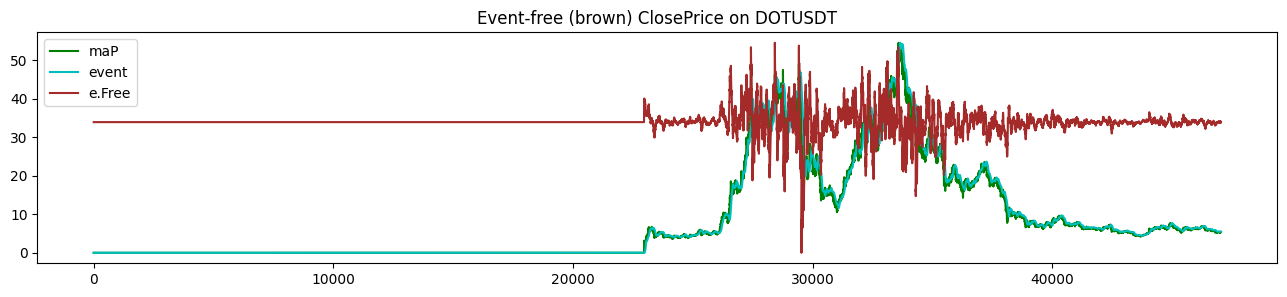

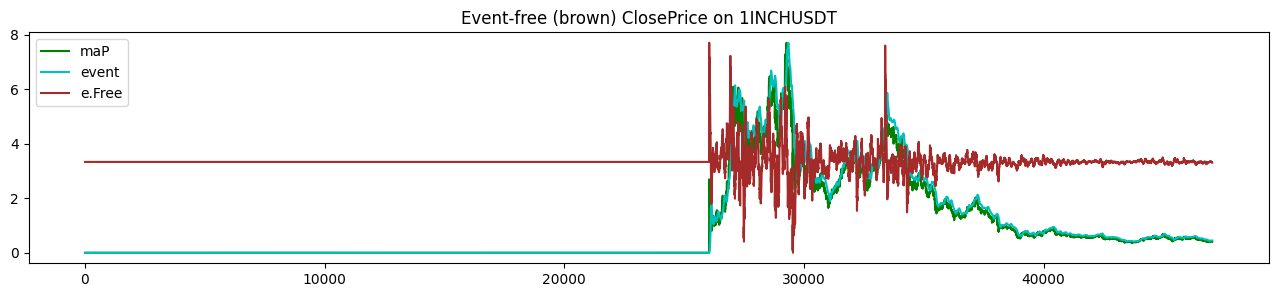

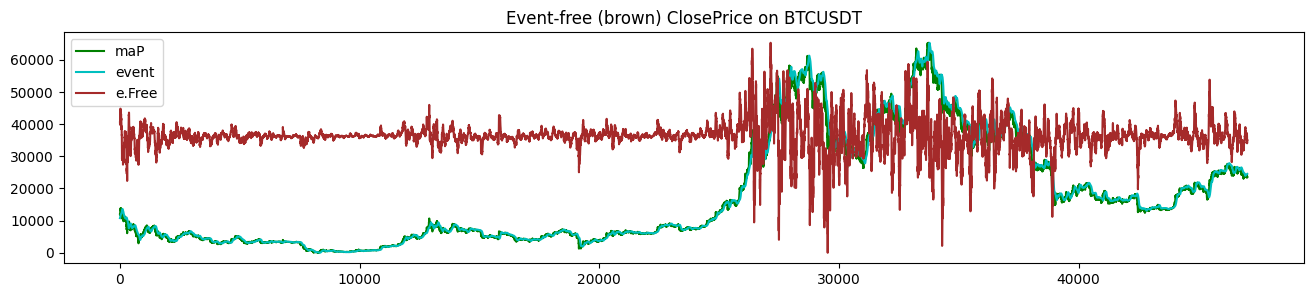

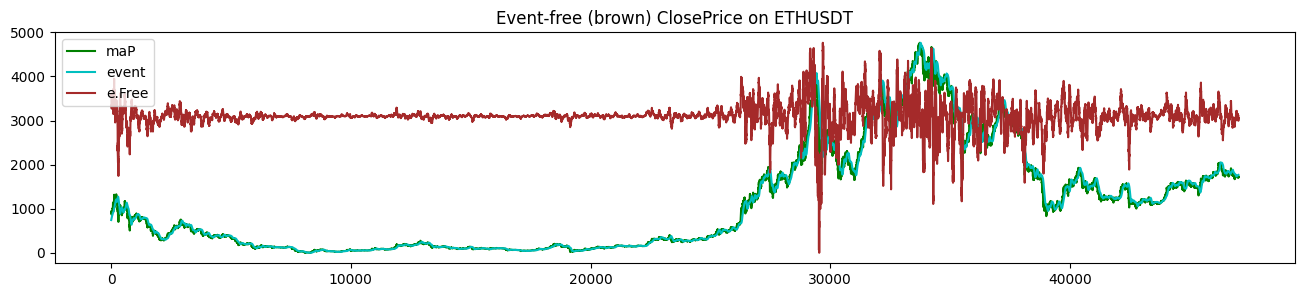

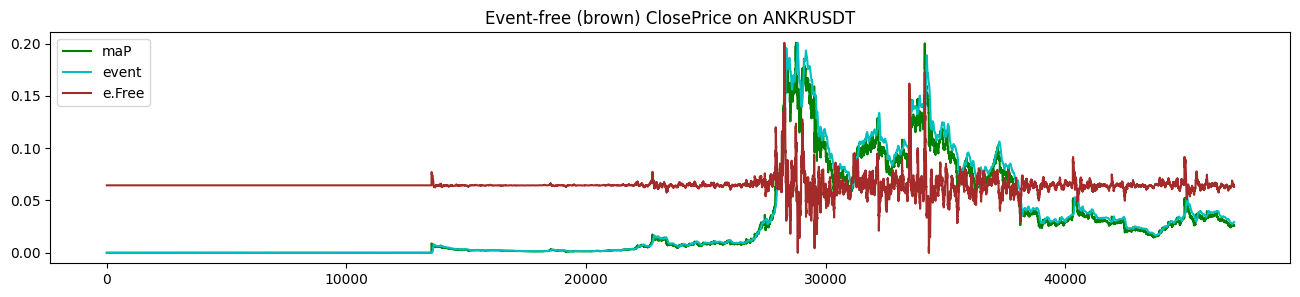

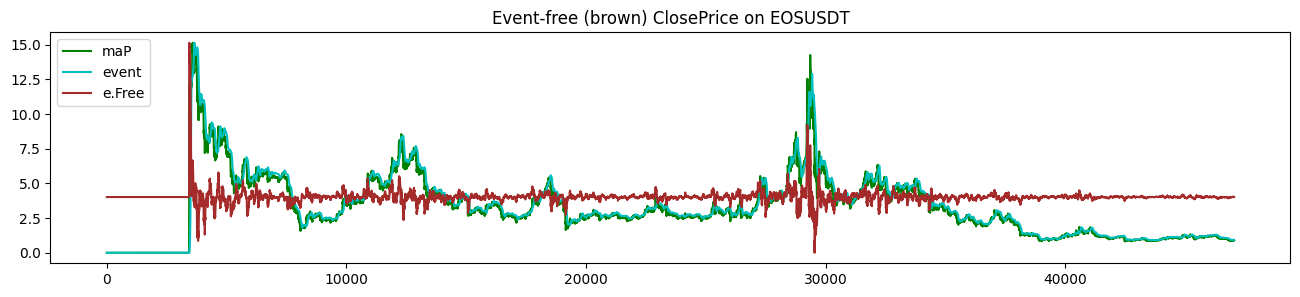

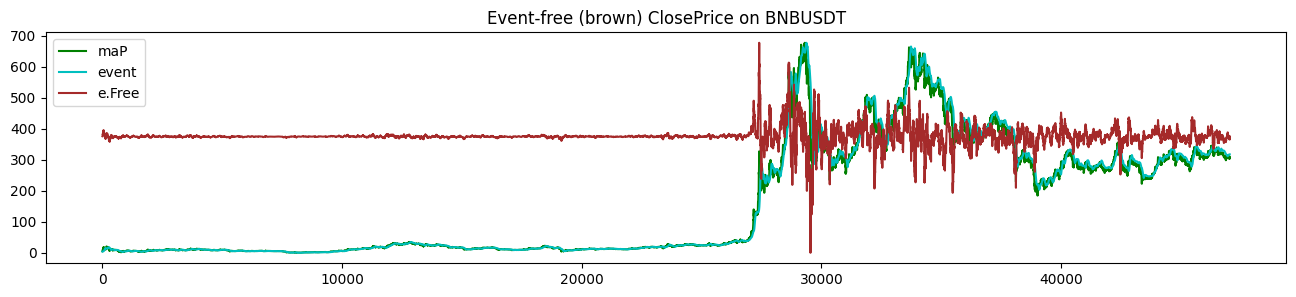

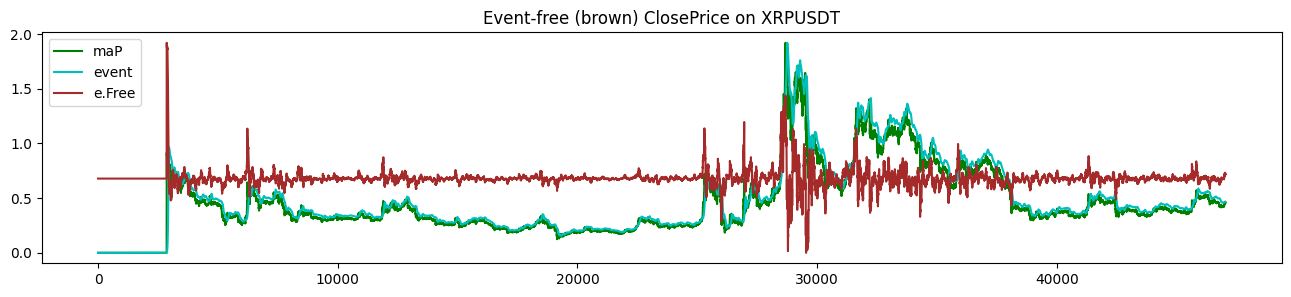

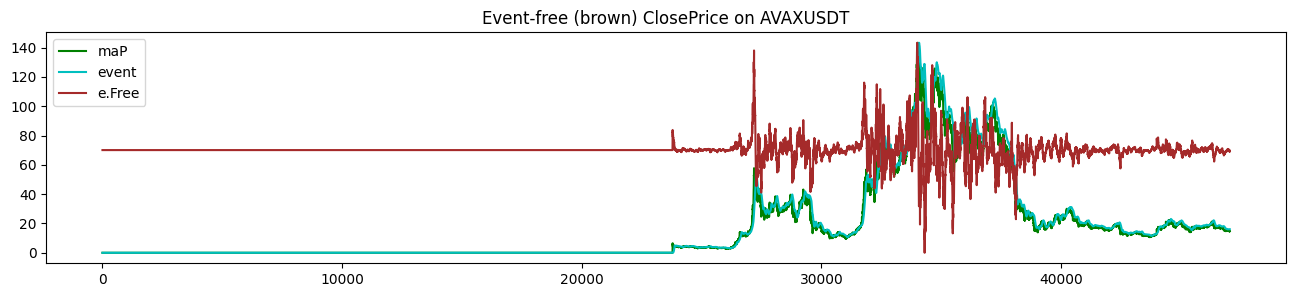

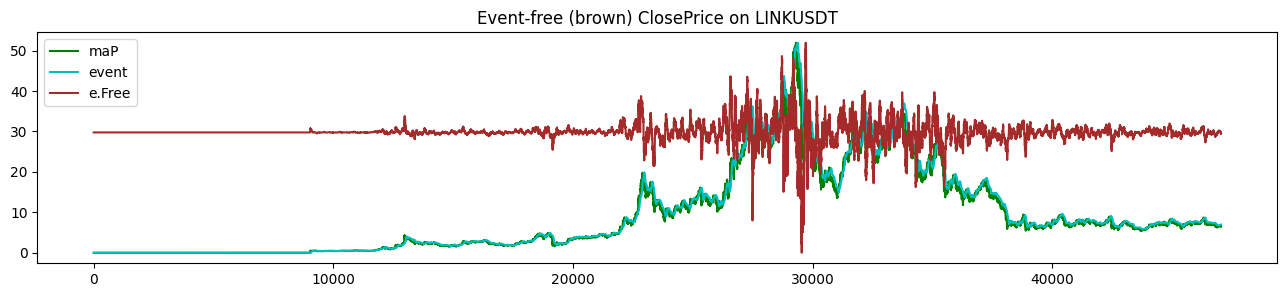

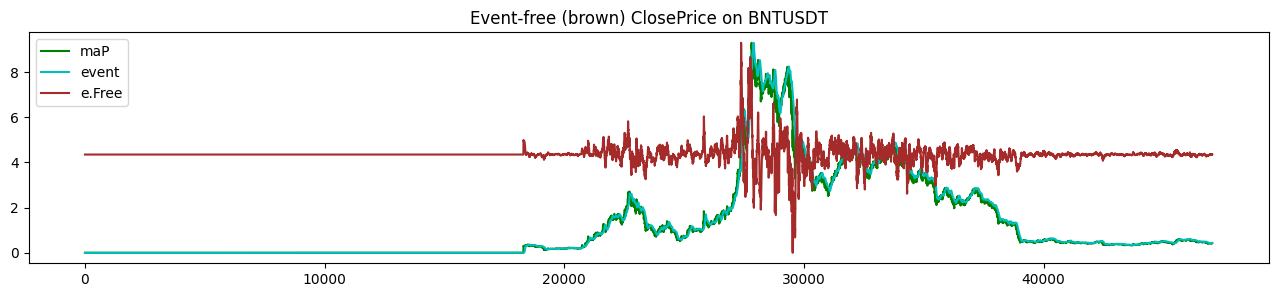

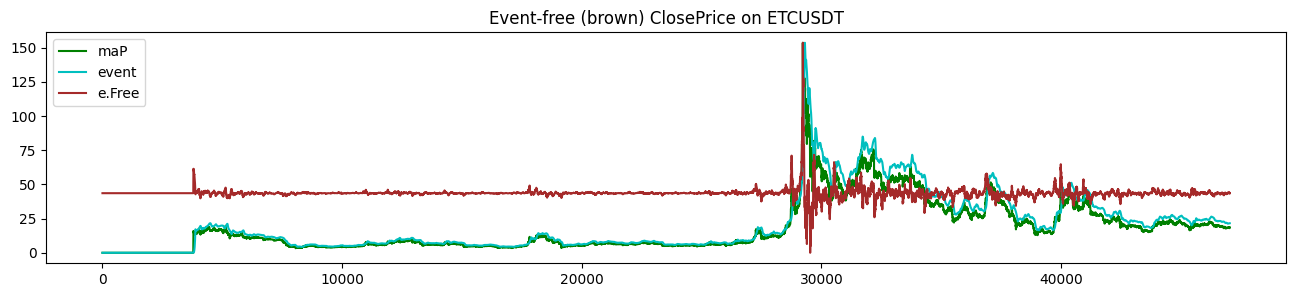

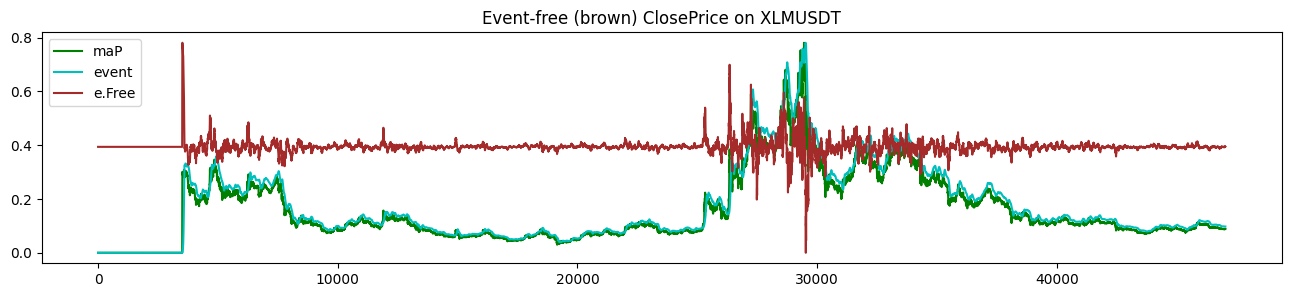

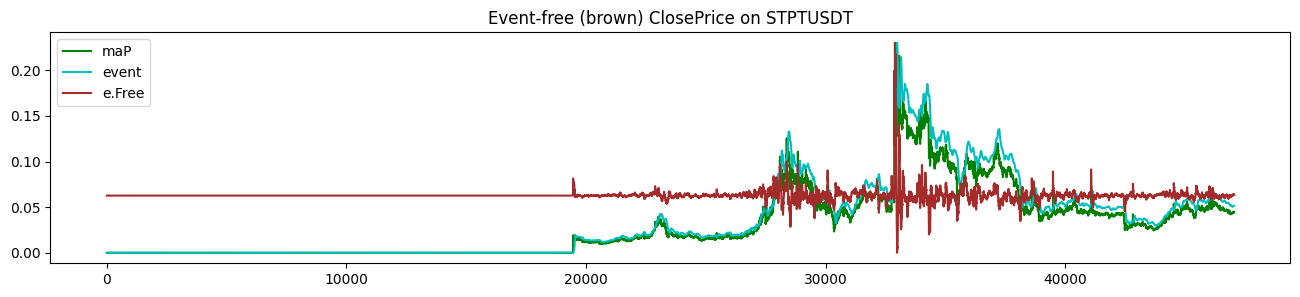

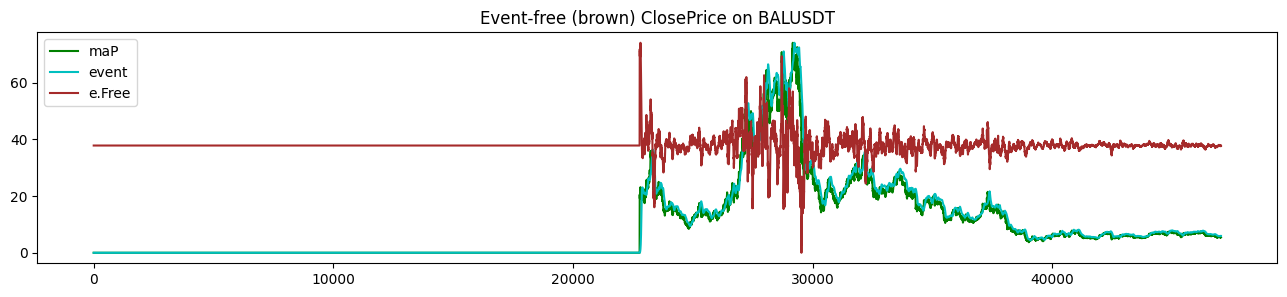

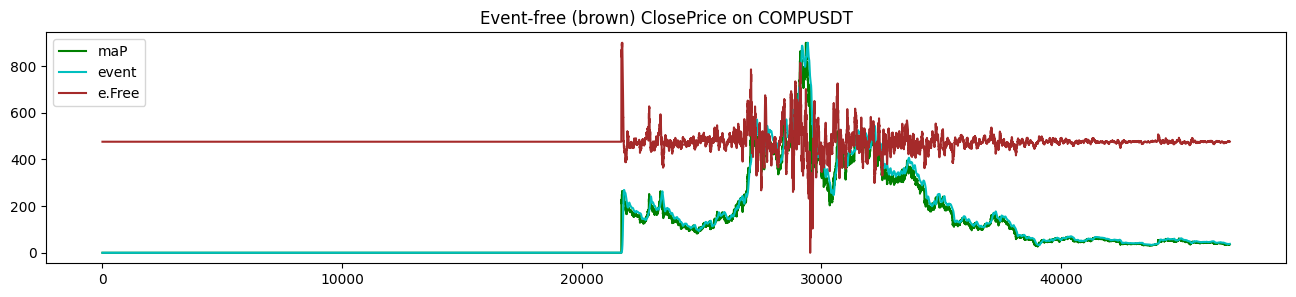

(47038, 336, 3)


In [46]:
#==================== Generate event-free data into Data ====================
# Data loses heading items.
# Do it before: Permute Data in time

smallSigma = 1
largeSigma = 30

alpha = 3; beta = 3 # beta is used in 'get_plot_log_feature'. Ugly coupling.
event_free_data_loss = 3 * ( alpha * smallSigma + largeSigma)
eFree = np.zeros( (Data.shape[0] - event_free_data_loss, len(chosen_markets), len(chosen_fields)), dtype = np.float32 )

for market in chosen_markets:
    for field in chosen_fields:
        sSigma = smallSigma
        if enFields[field] == 'BaseVolume': sSigma = smallSigma * alpha
        P, maP, logP, log_maP, event, eventFree = \
        get_plot_log_feature_no_log(markets[market], enFields[field], Data[:, market, field], sSigma, largeSigma, Data.shape[0] - event_free_data_loss, NoChart = False)
        Data[event_free_data_loss:, market, field] = eventFree

Data = Data[event_free_data_loss: ]

print(Data.shape)

In [47]:
#==================== Define time features, to augment Data with ====================
# Do it before: Permute Data in time

hourly = np.sin( 2 * np.pi / (60*60) * timestamps_abs )
daily = np.sin( 2 * np.pi / (60*60*24) * timestamps_abs )
weekly = np.sin( 2 * np.pi / (60*60*24*7) * timestamps_abs )
yearly = np.sin( 2 * np.pi / (60*60*24*365) * timestamps_abs )

Time = np.stack([hourly, daily, weekly, yearly], axis=1)
size_time = Time.shape[1]

Time = Time[event_free_data_loss: ]
assert Data.shape[0] == Time.shape[0]
print(table.shape, Time.shape)

# table = np.insert(table, 0, hourly.reshape(1), axis=0)

(47137, 336, 3) (47038, 4)


In [48]:
#==================== Standardize Data on chosen markets and fields ====================

Standard = []

for market in chosen_markets:
    for field in chosen_fields:
        nzPs = np.where( Data[:, market, field] != 0.0 ) [0]
        mu = np.average(Data[nzPs, market, field])
        sigma = np.std(Data[nzPs, market, field])
        standard = (Data[nzPs, market, field] - mu) / (sigma + 1e-15)
        Standard.append( (market, field, mu, sigma) )
        Data[nzPs, market, field] = standard

Standard = np.array(Standard)

In [49]:
# Trim in time dimension

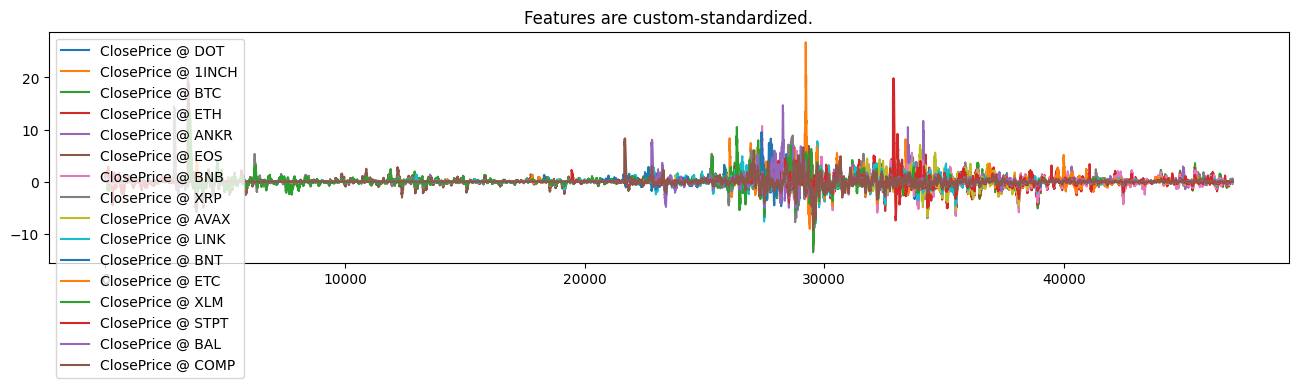

In [50]:
fig = plt.figure(figsize=(16,3))
ax = fig.add_subplot(111)
ax.set_title("Features are custom-standardized.")
for market in chosen_markets:
    for field in chosen_fields:
        ax.plot(Data[:, market, field], label = "{} @ {}".format(enFields[field], markets[market][:-4])) # -4: 'USDT'
ax.legend(loc = 'upper left')
plt.show()

In [51]:
#==================== Define input sequence and output sequence ====================

Nx = 500
Ny = 5
Ns = 5
BatchSize = 64

sample_anchors = np.array(range(0, Data.shape[0] - Nx - Ny + 1, Ns))
print(Data.shape[0], len(sample_anchors), sample_anchors, sample_anchors[-1])
print(Data.shape[0], sample_anchors[ -1 ], sample_anchors[ -1 ] + Nx + Ny, sample_anchors[ -1 ] + Ns, sample_anchors[ -1 ] + Ns + Nx + Ny)

for _ in range(10):
    permute = np.random.permutation(sample_anchors.shape[0])
    sample_anchors = sample_anchors[permute]

from sklearn.model_selection import train_test_split
sample_anchores_t, sample_anchores_v = train_test_split(sample_anchors, test_size=0.30, random_state=42)
print(sample_anchores_t.shape, sample_anchores_v.shape)

sample_anchores_t = tuple(sample_anchores_t)
sample_anchores_v = tuple(sample_anchores_v)

47038 9307 [    0     5    10 ... 46520 46525 46530] 46530
47038 46530 47035 46535 47040
(6514,) (2793,)


In [52]:
#==================== Create train/valid datasets ====================

nFiles_t = 70
nFiles_v = 30
n_readers = 10
shuffle_batch = 300
prefetch = 3

dir_datasets = "/mnt/data/Trading/Datasets/"

name_plus_t = CandleFile+'_t'
name_plus_v = CandleFile+'_v'
name_prefix_t = os.path.join(dir_datasets, name_plus_t)
name_prefix_v = os.path.join(dir_datasets, name_plus_v)

reuse_files = False #------------------------------------------------------------------------------------------------------- 

if reuse_files:
    import re
    filenames_train = [ os.path.join(dir_datasets, x) for x in os.listdir(dir_datasets) if re.match(name_plus_t, x)]
    filenames_valid = [ os.path.join(dir_datasets, x) for x in os.listdir(dir_datasets) if re.match(name_plus_v, x)]
else:
    os.system("rm {}/*{}*".format(dir_datasets, name_plus_t))
    os.system("rm {}/*{}*".format(dir_datasets, name_plus_v))
    filenames_train = save_to_multiple_csv_files(Data, Time, sample_anchores_t, name_prefix_t, Nx, x_indices, Ny, y_indices, header=None, n_parts=nFiles_t)
    filenames_valid = save_to_multiple_csv_files(Data, Time, sample_anchores_v, name_prefix_v, Nx, x_indices, Ny, y_indices, header=None, n_parts=nFiles_v)

# sample_anchores are already shuffled. But we need to shuffle datasets again, because it will reshuffle at every epoch.
Dataset_train = csv_reader_dataset(filenames_train, Nx, size_x, Ny, size_y, size_time,
                             n_parse_threads=5, batch_size=BatchSize, shuffle_buffer_size=BatchSize*shuffle_batch, n_readers=n_readers)
Dataset_train = Dataset_train.prefetch(prefetch)

Dataset_valid = csv_reader_dataset(filenames_valid, Nx, size_x, Ny, size_y, size_time,
                             n_parse_threads=5, batch_size=BatchSize, shuffle_buffer_size=BatchSize*shuffle_batch, n_readers=n_readers)
Dataset_valid = Dataset_valid.prefetch(prefetch)

In [53]:
for element in Dataset_train:
    print(element)
    break

(<tf.Tensor: shape=(64, 500, 20), dtype=float32, numpy=
array([[[-3.77947062e-01, -8.97979379e-01, -1.00057662e+00, ...,
          6.04826259e-12, -6.95096270e-13, -8.84067535e-01],
        [-3.68229419e-01, -8.71873260e-01, -9.40686166e-01, ...,
         -2.58819044e-01, -3.73911932e-02, -8.84402514e-01],
        [-3.79507482e-01, -8.78909230e-01, -9.58111703e-01, ...,
         -5.00000000e-01, -7.47300908e-02, -8.84737015e-01],
        ...,
        [ 2.11460784e-01,  4.39550102e-01,  1.38058722e+00, ...,
          9.65925813e-01,  2.58819044e-01, -9.91584718e-01],
        [ 2.06336543e-01,  4.16785032e-01,  1.36376023e+00, ...,
          1.00000000e+00,  2.22520933e-01, -9.91677344e-01],
        [ 1.94146261e-01,  3.72982830e-01,  1.32809877e+00, ...,
          9.65925813e-01,  1.85911611e-01, -9.91769433e-01]],

       [[ 3.50245923e-01,  1.81331873e-01,  4.07717466e-01, ...,
         -7.07106769e-01, -1.11964479e-01, -9.40588892e-01],
        [ 3.33754152e-01,  1.02203384e-01,  4.6

In [54]:
def mae_last_step(Y_true, Y_pred):
    return keras.mean(keras.abs(Y_pred[:, -1] - Y_true[:, -1]))

In [55]:
#==================== Define 'huber_loss' ====================

def huber_loss(y_true, y_pred, max_grad=0.2):   # default: max_grad = 1.0
    err = tf.abs(y_true - y_pred, name='abs')
    mg = tf.constant(max_grad, name='max_grad')
    lin = mg * (err - 0.5 * mg)
    quad = 0.5 * err * err
    return tf.where(err < mg, quad, lin)

In [56]:
#==================== Define RegularizedLSTM ====================

from functools import partial
RegularizedLSTM = partial(keras.layers.LSTM,
                          return_sequences=True,
                          kernel_regularizer=keras.regularizers.l2(1e-4),
                          recurrent_regularizer=keras.regularizers.l2(1e-4))

In [57]:
#==================== Define build_model ====================


def build_model(input_dim, output_size, allow_cudnn_kernel=True):

    units = max(input_dim, output_size)

    # CuDNN is only available at the layer level, and not at the cell level.
    # This means `LSTM(units)` will use the CuDNN kernel,
    # while RNN(LSTMCell(units)) will run on non-CuDNN kernel.
    if allow_cudnn_kernel:
        # The LSTM layer with default options uses CuDNN.

        inputs = keras.Input( shape = (None, input_dim), name = "candles" )
        x = keras.layers.BatchNormalization()(inputs)       
        x = RegularizedLSTM(units, kernel_initializer="lecun_normal")(x)
        x = keras.layers.BatchNormalization()(x)
        x = RegularizedLSTM(units, kernel_initializer="lecun_normal")(x)
        x = keras.layers.BatchNormalization()(x)
        x = RegularizedLSTM(units, kernel_initializer="lecun_normal")(x)
        x = keras.layers.BatchNormalization()(x)
        x = RegularizedLSTM(units, kernel_initializer="lecun_normal")(x)
        x = keras.layers.BatchNormalization()(x)
        x = RegularizedLSTM(units, kernel_initializer="lecun_normal")(x)
        x = keras.layers.BatchNormalization()(x)
        x = RegularizedLSTM(units, kernel_initializer="lecun_normal")(x)
        x = keras.layers.BatchNormalization()(x)
        x = RegularizedLSTM(units, kernel_initializer="lecun_normal")(x)
        x = keras.layers.BatchNormalization()(x)
        x = RegularizedLSTM(units, kernel_initializer="lecun_normal")(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.LSTM(units, kernel_initializer="lecun_normal")(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Dense(units, activation="selu", kernel_initializer="lecun_normal")(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Dense(units, activation="selu", kernel_initializer="lecun_normal")(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Dense(units, activation="selu", kernel_initializer="lecun_normal")(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Dense(units, activation="selu", kernel_initializer="lecun_normal")(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Dense(units, activation="selu", kernel_initializer="lecun_normal")(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Dense(units, activation="selu", kernel_initializer="lecun_normal")(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Dense(units, activation="selu", kernel_initializer="lecun_normal")(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Dense(units, activation="selu", kernel_initializer="lecun_normal")(x)
        x = keras.layers.BatchNormalization()(x)
        outputs = keras.layers.Dense(output_size, activation="selu", kernel_initializer="lecun_normal")(x)

        model = keras.Model( 
            inputs = inputs, 
            outputs = outputs,
            name = "LSTMDense_model"
        )

        model.compile(
            # loss=keras.losses.MeanAbsoluteError(name='loss'),
            loss=keras.losses.MeanSquaredError(name='loss'),
            optimizer=keras.optimizers.Adam(
                learning_rate=0.001,  # def lr = 0.001
                beta_1=0.9,
                beta_2=0.999, 
                epsilon=1e-07
            ),
            metrics=keras.metrics.MSE,
        )

    return model

In [58]:
#==================== Build model ====================

model = build_model(size_x + size_time, Ny * size_y, allow_cudnn_kernel=True)
# model = build_model(allow_cudnn_kernel=True)
model.summary()
# keras.utils.plot_model(model, show_shapes=True)

Model: "LSTMDense_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 candles (InputLayer)        [(None, None, 20)]        0         
                                                                 
 batch_normalization (BatchN  (None, None, 20)         80        
 ormalization)                                                   
                                                                 
 lstm (LSTM)                 (None, None, 50)          14200     
                                                                 
 batch_normalization_1 (Batc  (None, None, 50)         200       
 hNormalization)                                                 
                                                                 
 lstm_1 (LSTM)               (None, None, 50)          20200     
                                                                 
 batch_normalization_2 (Batc  (None, None, 50)     

In [59]:
#==================== Fit model ====================

# options = tf.data.Options()
# options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.OFF
# train_data = Dataset_train.with_options(options)
# val_data = Dataset_valid.with_options(options)

history = model.fit(Dataset_train, validation_data=Dataset_valid, epochs=150)
# history_2= model.fit(Dataset_train, validation_data=Dataset_valid, epochs=10, initial epoch=history_1.epoch(-1) )

Epoch 1/150


2023-05-31 19:22:01.261118: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8200
2023-05-31 19:22:02.901662: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


102/102 [==============================] - 90s 533ms/step - loss: 1.6671 - mean_squared_error: 1.4673 - val_loss: 1.2620 - val_mean_squared_error: 1.0622
Epoch 2/150
102/102 [==============================] - 53s 494ms/step - loss: 1.3059 - mean_squared_error: 1.1062 - val_loss: 1.1208 - val_mean_squared_error: 0.9212
Epoch 3/150
102/102 [==============================] - 57s 535ms/step - loss: 1.1423 - mean_squared_error: 0.9427 - val_loss: 1.0298 - val_mean_squared_error: 0.8304
Epoch 4/150
102/102 [==============================] - 56s 518ms/step - loss: 1.0678 - mean_squared_error: 0.8684 - val_loss: 0.9748 - val_mean_squared_error: 0.7755
Epoch 5/150
102/102 [==============================] - 54s 503ms/step - loss: 1.0229 - mean_squared_error: 0.8237 - val_loss: 0.9463 - val_mean_squared_error: 0.7472
Epoch 6/150
102/102 [==============================] - 54s 502ms/step - loss: 0.9901 - mean_squared_error: 0.7911 - val_loss: 0.9201 - val_mean_squared_error: 0.7211
Epoch 7/150
102/

102/102 [==============================] - 52s 460ms/step - loss: 0.6845 - mean_squared_error: 0.4930 - val_loss: 0.6349 - val_mean_squared_error: 0.4435
Epoch 51/150
102/102 [==============================] - 49s 442ms/step - loss: 0.6781 - mean_squared_error: 0.4868 - val_loss: 0.6326 - val_mean_squared_error: 0.4414
Epoch 52/150
102/102 [==============================] - 48s 443ms/step - loss: 0.6855 - mean_squared_error: 0.4943 - val_loss: 0.6312 - val_mean_squared_error: 0.4402
Epoch 53/150
102/102 [==============================] - 47s 435ms/step - loss: 0.6775 - mean_squared_error: 0.4866 - val_loss: 0.6275 - val_mean_squared_error: 0.4367
Epoch 54/150
102/102 [==============================] - 48s 443ms/step - loss: 0.6797 - mean_squared_error: 0.4889 - val_loss: 0.6251 - val_mean_squared_error: 0.4345
Epoch 55/150
102/102 [==============================] - 48s 447ms/step - loss: 0.6681 - mean_squared_error: 0.4775 - val_loss: 0.6204 - val_mean_squared_error: 0.4299
Epoch 56/15

102/102 [==============================] - 53s 493ms/step - loss: 0.5797 - mean_squared_error: 0.3982 - val_loss: 0.5367 - val_mean_squared_error: 0.3553
Epoch 100/150
102/102 [==============================] - 53s 489ms/step - loss: 0.5739 - mean_squared_error: 0.3926 - val_loss: 0.5357 - val_mean_squared_error: 0.3545
Epoch 101/150
102/102 [==============================] - 54s 498ms/step - loss: 0.5692 - mean_squared_error: 0.3881 - val_loss: 0.5330 - val_mean_squared_error: 0.3520
Epoch 102/150
102/102 [==============================] - 54s 502ms/step - loss: 0.5649 - mean_squared_error: 0.3840 - val_loss: 0.5292 - val_mean_squared_error: 0.3484
Epoch 103/150
102/102 [==============================] - 53s 490ms/step - loss: 0.5636 - mean_squared_error: 0.3830 - val_loss: 0.5271 - val_mean_squared_error: 0.3466
Epoch 104/150
102/102 [==============================] - 52s 487ms/step - loss: 0.5646 - mean_squared_error: 0.3842 - val_loss: 0.5241 - val_mean_squared_error: 0.3438
Epoch 

Epoch 148/150
102/102 [==============================] - 50s 446ms/step - loss: 0.4719 - mean_squared_error: 0.3012 - val_loss: 0.4336 - val_mean_squared_error: 0.2631
Epoch 149/150
102/102 [==============================] - 49s 429ms/step - loss: 0.4666 - mean_squared_error: 0.2962 - val_loss: 0.4338 - val_mean_squared_error: 0.2635
Epoch 150/150
102/102 [==============================] - 49s 434ms/step - loss: 0.4624 - mean_squared_error: 0.2921 - val_loss: 0.4337 - val_mean_squared_error: 0.2636


In [60]:
#==================== Define plot_history ====================

def plot_history(history, loss="loss"):
    train_losses = history.history[loss]
    valid_losses = history.history["val_" + loss]
    n_epochs = len(history.epoch)
    minloss = min( np.min(valid_losses), np.min(train_losses) )
    maxloss = max( np.max(valid_losses), np.max(train_losses) )
    
    plt.plot(train_losses, color="b", label="Train")
    plt.plot(valid_losses, color="r", label="Validation")
    plt.plot([0, n_epochs], [minloss, minloss], "k--",
             label="Min val: {:.5f}".format(minloss))
    plt.axis([0, n_epochs, minloss/1.05, maxloss*1.05])
    plt.legend()
    plt.show()

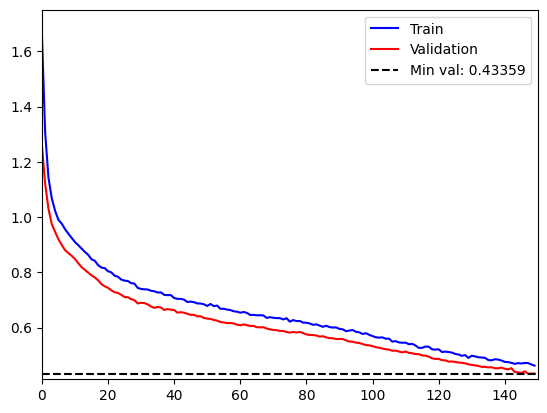

In [61]:
plot_history(history)

In [62]:
# history_2= model.fit(Dataset_train, validation_data=Dataset_valid, epochs=10, initial epoch=history_1.epoch(-1) )

In [65]:
def plot_log_history(history, loss="loss"):
    log_train_losses = np.log(history.history[loss])
    log_valid_losses = np.log(history.history["val_" + loss])
    n_epochs = len(history.epoch)
    minloss = min( np.min(log_valid_losses), np.min(log_train_losses) )
    maxloss = max( np.max(log_valid_losses), np.max(log_train_losses) )
    
    plt.plot(log_train_losses, color="b", label="log.Train")
    plt.plot(log_valid_losses, color="r", label="log.Validation")
    plt.plot([0, n_epochs], [minloss, minloss], "k--",
             label="Min val: {:.5f}".format(minloss))
    plt.axis([0, n_epochs, minloss/1.05, maxloss*1.05])
    plt.legend()
    plt.show()

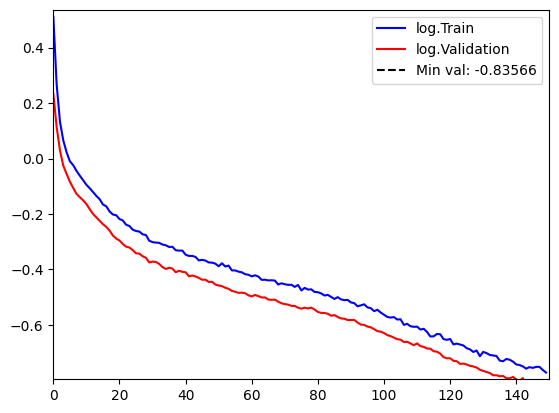

In [66]:
plot_log_history(history)

In [67]:
def masked_loss(label, pred):
    mask = label != 0

    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_object(label, pred)

    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
    return loss


def masked_accuracy(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred

    mask = label != 0

    match = match & mask

    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [ ]:
history = model.fit(Dataset_train, validation_data=Dataset_valid, epochs=150)

Epoch 1/150
102/102 [==============================] - 59s 530ms/step - loss: 0.4602 - mean_squared_error: 0.2903 - val_loss: 0.4325 - val_mean_squared_error: 0.2626
Epoch 2/150
102/102 [==============================] - 53s 470ms/step - loss: 0.4583 - mean_squared_error: 0.2885 - val_loss: 0.4291 - val_mean_squared_error: 0.2595
Epoch 3/150
102/102 [==============================] - 53s 489ms/step - loss: 0.4592 - mean_squared_error: 0.2897 - val_loss: 0.4285 - val_mean_squared_error: 0.2591
Epoch 4/150
102/102 [==============================] - 61s 572ms/step - loss: 0.4603 - mean_squared_error: 0.2910 - val_loss: 0.4277 - val_mean_squared_error: 0.2585
Epoch 5/150
102/102 [==============================] - 55s 513ms/step - loss: 0.4656 - mean_squared_error: 0.2965 - val_loss: 0.4246 - val_mean_squared_error: 0.2556
Epoch 6/150
102/102 [==============================] - 58s 536ms/step - loss: 0.4660 - mean_squared_error: 0.2971 - val_loss: 0.4267 - val_mean_squared_error: 0.2579
Epoc